In [20]:
import os
from chemicals.chemical import Chemical
from database.database import Database, LiquidMasterDataSet
from pprint import pprint, PrettyPrinter
import numpy as np
import pandas as pd

pp = PrettyPrinter(width=80, compact=True)
%reload_ext autoreload
%autoreload 1
%aimport chemicals.chemical
%aimport database.database

Inorganic content refers to all elements except carbon and hydrogen and lithium. Organic content refers to only carbon. InOr is a ratio between inorganic content and organic content. Hydrogen and lithium were excluded from the two categories, because they are well known to be present in both organic and inorganic materials.

# Load data

In [21]:
db = Database(db="FMT")
df = db.pull(table="Liquid Master Table")

ds_lm = LiquidMasterDataSet(df)
ds_lm.map_names()
ds_lm.normalize_components(by="total_mass(g)", inplace=True)

df_chem = Chemical.from_csv("../chemicals/chemicals_database.csv")

/home/zhu/Documents/botorch_generation/database/database.py:105: RuntimeWarning: invalid value encountered in divide
  normalized_components = components / total_mass


`ds_lm` is the loaded from Liquid Master Table

**Note!!**  
There are 170 out of 748 electrolytes that don't have an LCE value.  
These entries are discarded for now until LCE value are added to database.

In [22]:
recipes = ds_lm.dataframe
recipes.rename(columns={"Electrolyte ID": "id"}, inplace=True)
recipes.dropna(subset=["LCE"], inplace=True)
recipes.reset_index(inplace=True, drop=True)
# Make sure the electrolyte ID's are unique
assert len(recipes["id"].unique()) == len(recipes["id"])
print(f"Number of electrolytes: {len(recipes)}")
print(recipes.columns)

Number of electrolytes: 578
Index(['id', 'lab_batch', 'note', 'total_mass(g)', 'generation_method',
       'generation_project', 'experiment', 'LiPF6', 'LiTFSI', 'LiFSI',
       'LiPO2F2', 'LiClO4', 'LiBOB', 'LiBF4', 'LiTf', 'L1', 'LiTDI', 'LiDFOB',
       'EC', 'DEC', 'DMC', 'EMC', 'DOL', 'DME', 'PC', 'diglyme', 'TTE',
       'Sulfolane', 'TMP', 'BTC', 'DMDMOS', 'VC', 'FEC', 'SN', 'PS', 'DTO',
       'TMSPi', 'BTFE', 'AN', 'TFEO', 'BTFEC', 'TMSNCS', 'LiAlO2',
       'Montmorillonite', 'Al2O3', 'LiNO3', 'P2O5', 'Li2S', 'CsNO3', 'S1',
       'S2', 'S3', 'C1', 'C2', 'C3', 'E1', 'DTD', 'Li2O', 'TFMB',
       'Conductivity', 'Voltage', 'Cycles', 'LCE', 'Initial Li efficiency',
       'generation_id', 'Predicted Conductivity', 'Predicted Voltage',
       'Predicted LCE'],
      dtype='object')


`df_chem` is the chemical information table

In [23]:
df_chem.columns

Index(['ID', 'Name', 'Formula', 'IUPAC', 'SMILES', 'Type', 'MW (g/mol)',
       'Density (g/mL)', 'Molarity (mol/L)', 'Source', 'Notes', 'ELE_H',
       'ELE_Li', 'ELE_B', 'ELE_C', 'ELE_N', 'ELE_O', 'ELE_F', 'ElE_AI',
       'ELE_Si', 'ELE_P', 'ELE_S', 'ELE_Cl', 'ElE_As', 'ELE_Rb', 'ELE_Cs',
       'ELE_Sn'],
      dtype='object')

Below is the chemical information and amount of atoms for the chemicals used in the Liquid Master Table

In [24]:
select_chemicals = df_chem["Name"].isin(ds_lm.chemical_names) | df_chem["IUPAC"].isin(ds_lm.chemical_names)
select_elements = df_chem.columns.str.contains("ELE_") | df_chem.columns.isin(["Name", "Formula", "Type", "MW (g/mol)"])
df_chem.loc[select_chemicals, select_elements].fillna("")

,Name,Formula,Type,MW (g/mol),ELE_H,ELE_Li,ELE_B,ELE_C,ELE_N,ELE_O,ELE_F,ELE_Si,ELE_P,ELE_S,ELE_Cl,ELE_Rb,ELE_Cs,ELE_Sn
0,Al2O3,Al2O3,additive,101.96,,,,,,3.0,,,,,,,,
1,C1,CH4,additive,16.043,4.0,,,1.0,,,,,,,,,,
2,C2,C2H6,additive,30.07,6.0,,,2.0,,,,,,,,,,
3,C3,C3H8,additive,44.097,8.0,,,3.0,,,,,,,,,,
4,CsNO3,CsNO3,salt,194.91,,,,,1.0,3.0,,,,,,,1.0,
5,DTD,C2H2O3S,additive,124.12,2.0,,,2.0,,3.0,,,,1.0,,,,
6,E1,,additive,,,,,,,,,,,,,,,
7,Li2O,Li2O4,additive,29.88,,2.0,,,,4.0,,,,,,,,
8,P2O5,P2O5,additive,283.9,,,,,,5.0,,,2.0,,,,,
10,S1,S,additive,32.06,,,,,,,,,,1.0,,,,


# Feature Extraction

In [25]:
select_elements = df_chem.columns.str.contains("ELE_")

molar_elements_list = []
molar_elements_list_salt = []
molar_elements_list_solvent = []

for i in recipes.index:
    recipe = recipes.iloc[i] 
    recipe_elements = [] # molar amount of each element in each chemical in the recipe
    recipe_elements_salt = []
    recipe_elements_solvent = []
    for name in recipes.columns:
        if name not in ds_lm.chemical_names:
            continue
        try:
            # select chemical
            select_row = df_chem["Name"].isin([name]) | df_chem["IUPAC"].isin([name]) 
            chemical = df_chem.loc[select_row].squeeze().rename(name)
            # calculate total molar amount of the chemical
            molar_chemical = recipe[name] / chemical["MW (g/mol)"] # grams * (grams/mole)^-1
            # calculate total molar amount of each element in the chemical 
            molar_elements = chemical[select_elements] * molar_chemical 
            
            recipe_elements.append(molar_elements)
            if chemical["Type"] in ["solvent", "additive"]:
                recipe_elements_solvent.append(molar_elements)
            elif chemical["Type"] in ["salt"]:
                recipe_elements_salt.append(molar_elements)
        except:
            raise
    
    df_recipe_elements = pd.concat(recipe_elements, axis=1)
    molar_elements = df_recipe_elements.sum(axis=1)
    molar_elements["id"] = recipe["id"]
    molar_elements_list.append(molar_elements)
    
    df_recipe_elements_salt = pd.concat(recipe_elements_salt, axis=1)
    molar_elements_salt = df_recipe_elements_salt.sum(axis=1)
    molar_elements_salt["id"] = recipe["id"]
    molar_elements_list_salt.append(molar_elements_salt)

    df_recipe_elements_solvent = pd.concat(recipe_elements_solvent, axis=1)
    molar_elements_solvent = df_recipe_elements_solvent.sum(axis=1)
    molar_elements_solvent["id"] = recipe["id"]
    molar_elements_list_solvent.append(molar_elements_solvent)

    print(i, end="\r", flush=True)


In [26]:
df_molar_elements = pd.concat(molar_elements_list, axis=1).T
df_molar_elements.set_index(keys="id", inplace=True)

df_molar_elements_salt = pd.concat(molar_elements_list_salt, axis=1).T
df_molar_elements_salt.set_index(keys="id", inplace=True)

df_molar_elements_solvent = pd.concat(molar_elements_list_solvent, axis=1).T
df_molar_elements_solvent.set_index(keys="id", inplace=True)

From `df_molar_elements` we can extract:
|Feature|Acronym|Explanation|
|:---|:---:|:---|
| `Inorganic/organic ratio` | `InOr` | The ratio of inorganic to organic components |

According to..., the inorganic and organic are defined below:
>Inorganic content refers to all elements except carbon and hydrogen and lithium.  
>Organic content refers to only carbon. InOr is a ratio between inorganic content and organic content.  
>Hydrogen and lithium were excluded from the two categories, because they are well known to be present in both organic and inorganic materials.

In [27]:
df_molar_elements.head(5)

,ELE_H,ELE_Li,ELE_B,ELE_C,ELE_N,ELE_O,ELE_F,ELE_Si,ELE_P,ELE_S,ELE_Cl,ELE_Rb,ELE_Cs,ELE_Sn
id,,,,,,,,,,,,,,
20-1-1,0.05485,0.000763,0.0,0.032459,0.0,0.027418,0.004579,0.0,0.000763,0.0,0.0,0.0,0.0,0.0
20-1-2,0.054303,0.000902,0.0,0.032136,0.000145,0.02758,0.004539,0.0,0.000757,0.0,0.0,0.0,0.0,0.0
20-1-3,0.047768,0.000725,0.000278,0.029564,0.000417,0.031509,0.002685,0.0,0.00003,0.000834,0.0,0.0,0.0,0.0
20-1-4,0.023427,0.003467,0.0,0.011713,0.003467,0.025581,0.006934,0.0,0.0,0.006934,0.0,0.0,0.0,0.0
20-1-5,0.073002,0.000799,0.0,0.034182,0.000799,0.022307,0.004791,0.0,0.0,0.001597,0.0,0.0,0.0,0.0


In [28]:
select_inorganic = ~df_molar_elements.columns.isin(["ELE_C", "ELE_H", "ELE_Li"])
molar_inorganic = df_molar_elements.loc[:, select_inorganic].sum(axis=1)

select_organic = df_molar_elements.columns.isin(["ELE_C"])
molar_organic = df_molar_elements.loc[:, select_organic].sum(axis=1)

df_feature1 = (molar_inorganic / molar_organic).to_frame(name="InOr")
df_feature1.head(5)

,InOr
id,
20-1-1,1.009249
20-1-2,1.027542
20-1-3,1.209390
20-1-4,3.663744
20-1-5,0.862857


From `df_molar_elements_salt` we can extract:
|Feature|Acronym|Explanation|
|:---|:---:|:---|
| `Anion Oxygen ratio` | `aO` | The ratio of oxygens in salt (anions) to all atoms |
| `Anion Carbon ratio` | `aC` | The ratio of carbons in salt (anions) to all atoms |
| `Anion Fluorine ratio` | `aC` | The ratio of carbons in salt (anions) to all atoms |

In [29]:
df_molar_elements_salt.head(5)

,ELE_H,ELE_Li,ELE_B,ELE_C,ELE_N,ELE_O,ELE_F,ELE_Si,ELE_P,ELE_S,ELE_Cl,ELE_Rb,ELE_Cs,ELE_Sn
id,,,,,,,,,,,,,,
20-1-1,0.0,0.000763,0.0,0.0,0.0,0.0,0.004579,0.0,0.000763,0.0,0.0,0.0,0.0,0.0
20-1-2,0.0,0.000902,0.0,0.0,0.000145,0.000435,0.004539,0.0,0.000757,0.0,0.0,0.0,0.0,0.0
20-1-3,0.0,0.000725,0.000278,0.001946,0.000417,0.003892,0.002685,0.0,0.00003,0.000834,0.0,0.0,0.0,0.0
20-1-4,0.0,0.003467,0.0,0.0,0.003467,0.013867,0.006934,0.0,0.0,0.006934,0.0,0.0,0.0,0.0
20-1-5,0.0,0.000799,0.0,0.001597,0.000799,0.003194,0.004791,0.0,0.0,0.001597,0.0,0.0,0.0,0.0


In [30]:
df_total_molar = df_molar_elements.sum(axis=1).to_frame(name="Total")
print(len(df_total_molar))
df_total_molar.head(5)

578


,Total
id,
20-1-1,0.120832
20-1-2,0.120362
20-1-3,0.113810
20-1-4,0.081522
20-1-5,0.137477


In [31]:
df_anion_ratio = df_molar_elements_salt / df_total_molar.to_numpy()
df_feature2 = df_anion_ratio.loc[:, ["ELE_C", "ELE_O", "ELE_F"]]
df_feature2.rename(columns={"ELE_C": "aC", "ELE_O": "aO", "ELE_F": "aF"}, inplace=True)
df_feature2.head(5)

,aC,aO,aF
id,,,
20-1-1,0.0,0.0,0.037895
20-1-2,0.0,0.003615,0.037715
20-1-3,0.017098,0.034195,0.023589
20-1-4,0.0,0.170106,0.085053
20-1-5,0.011618,0.023235,0.034853


From `df_molar_elements_solvent` we can extract:
|Feature|Acronym|Explanation|
|:---|:---:|:---|
| `Solvent Oxygen ratio` | `sO` | The ratio of oxygens in solvent to all atoms |
| `Solvent Carbon ratio` | `sC` | The ratio of carbons in solvent to all atoms |
| `Solvent Fluorine ratio` | `sC` | The ratio of carbons in solvent to all atoms |

In [32]:
df_molar_elements_solvent.head(5)

,ELE_H,ELE_Li,ELE_B,ELE_C,ELE_N,ELE_O,ELE_F,ELE_Si,ELE_P,ELE_S,ELE_Cl,ELE_Rb,ELE_Cs,ELE_Sn
id,,,,,,,,,,,,,,
20-1-1,0.05485,0.0,0.0,0.032459,0.0,0.027418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20-1-2,0.054303,0.0,0.0,0.032136,0.0,0.027145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20-1-3,0.047768,0.0,0.0,0.027618,0.0,0.027618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20-1-4,0.023427,0.0,0.0,0.011713,0.0,0.011713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20-1-5,0.073002,0.0,0.0,0.032585,0.0,0.019113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
df_solvent_ratio = df_molar_elements_solvent / df_total_molar.to_numpy()
df_feature3 = df_solvent_ratio.loc[:, ["ELE_C", "ELE_O", "ELE_F"]]
df_feature3.rename(columns={"ELE_C": "sC", "ELE_O": "sO", "ELE_F": "sF"}, inplace=True)
df_feature3.head(5)

,sC,sO,sF
id,,,
20-1-1,0.268632,0.226905,0.0
20-1-2,0.266995,0.225527,0.0
20-1-3,0.242664,0.242664,0.0
20-1-4,0.143684,0.143684,0.0
20-1-5,0.237022,0.139026,0.0


From here we can further extract:
|Feature|Acronym|Explanation|
|:---|:---:|:---|
| `Oxygen ratio` | `O` | The ratio of oxygens in both solvent and anions to all atoms |
| `Carbon ratio` | `C` | The ratio of carbons in both solvent and anions to all atoms |
| `Fluorine ratio` | `C` | The ratio of carbons in both solvent and anions to all atoms |
| `Fluorine/Carbon ratio` | `FC` | The ratio of Fluorines to Carbons |
| `Oxygen/Carbon ratio` | `OC` | The ratio of Oxygen to Carbons |
| `Fluorine/Oxygen ratio` | `FO` | The ratio of Fluorine to Oxygens |


In [34]:
df_feature = pd.concat([df_feature1, df_feature2, df_feature3], axis=1)
df_feature.head(5)

,InOr,aC,aO,aF,sC,sO,sF
id,,,,,,,
20-1-1,1.009249,0.0,0.0,0.037895,0.268632,0.226905,0.0
20-1-2,1.027542,0.0,0.003615,0.037715,0.266995,0.225527,0.0
20-1-3,1.209390,0.017098,0.034195,0.023589,0.242664,0.242664,0.0
20-1-4,3.663744,0.0,0.170106,0.085053,0.143684,0.143684,0.0
20-1-5,0.862857,0.011618,0.023235,0.034853,0.237022,0.139026,0.0


In [35]:
df_feature4 = pd.DataFrame(
    {
        "O": df_feature["aO"] + df_feature["sO"],
        "C": df_feature["aC"] + df_feature["sC"],
        "F": df_feature["aF"] + df_feature["sF"],
    }
)
df_feature4.head(5)

,O,C,F
id,,,
20-1-1,0.226905,0.268632,0.037895
20-1-2,0.229142,0.266995,0.037715
20-1-3,0.276859,0.259761,0.023589
20-1-4,0.31379,0.143684,0.085053
20-1-5,0.162261,0.24864,0.034853


In [36]:
df_feature5 = pd.DataFrame(
    {
        "FC": df_feature4["F"] / df_feature4["C"],
        "FO": df_feature4["F"] / df_feature4["O"],
        "OC": df_feature4["O"] / df_feature4["C"],
    }
)
df_feature5.head(5)

,FC,FO,OC
id,,,
20-1-1,0.141067,0.167008,0.844671
20-1-2,0.141258,0.164592,0.858228
20-1-3,0.09081,0.085202,1.06582
20-1-4,0.591943,0.27105,2.183886
20-1-5,0.140175,0.214796,0.652595


## The final feature dataframe

In [37]:
df_feature = pd.concat([df_feature1, df_feature2, df_feature3, df_feature4, df_feature5], axis=1)
df_feature.head(5)

,InOr,aC,aO,aF,sC,sO,sF,O,C,F,FC,FO,OC
id,,,,,,,,,,,,,
20-1-1,1.009249,0.0,0.0,0.037895,0.268632,0.226905,0.0,0.226905,0.268632,0.037895,0.141067,0.167008,0.844671
20-1-2,1.027542,0.0,0.003615,0.037715,0.266995,0.225527,0.0,0.229142,0.266995,0.037715,0.141258,0.164592,0.858228
20-1-3,1.209390,0.017098,0.034195,0.023589,0.242664,0.242664,0.0,0.276859,0.259761,0.023589,0.09081,0.085202,1.06582
20-1-4,3.663744,0.0,0.170106,0.085053,0.143684,0.143684,0.0,0.31379,0.143684,0.085053,0.591943,0.27105,2.183886
20-1-5,0.862857,0.011618,0.023235,0.034853,0.237022,0.139026,0.0,0.162261,0.24864,0.034853,0.140175,0.214796,0.652595


# Calculate log CE
For those `LCE>=1` , adjust to `LCE=0.9999` to avoid log warning.

In [38]:
df_lce = recipes.set_index(keys="id").loc[:, ["LCE"]]
# df_lce.loc[df_lce["LCE"]<=0] = 0.0001
df_lce.loc[df_lce["LCE"]>=1] = 0.9999
df_lce.head(5)

,LCE
id,
20-1-1,0.767442
20-1-2,0.677419
20-1-3,0.902913
20-1-4,0.000000
20-1-5,0.000000


Transform `LCE` to `LLCE` (log LCE) using $LLCE = −log (1 – LCE)$

In [39]:
log_lce = lambda x: - np.log10(1 - x)
df_llce = log_lce(df_lce).rename(columns={"LCE": "LLCE"})
df_llce.head(5)

,LLCE
id,
20-1-1,0.633469
20-1-2,0.491361
20-1-3,1.012839
20-1-4,-0.000000
20-1-5,-0.000000


# Final dataset

In [40]:
df_final = pd.concat([df_feature, df_llce], axis=1)
df_final.head(5)

,InOr,aC,aO,aF,sC,sO,sF,O,C,F,FC,FO,OC,LLCE
id,,,,,,,,,,,,,,
20-1-1,1.009249,0.0,0.0,0.037895,0.268632,0.226905,0.0,0.226905,0.268632,0.037895,0.141067,0.167008,0.844671,0.633469
20-1-2,1.027542,0.0,0.003615,0.037715,0.266995,0.225527,0.0,0.229142,0.266995,0.037715,0.141258,0.164592,0.858228,0.491361
20-1-3,1.209390,0.017098,0.034195,0.023589,0.242664,0.242664,0.0,0.276859,0.259761,0.023589,0.09081,0.085202,1.06582,1.012839
20-1-4,3.663744,0.0,0.170106,0.085053,0.143684,0.143684,0.0,0.31379,0.143684,0.085053,0.591943,0.27105,2.183886,-0.000000
20-1-5,0.862857,0.011618,0.023235,0.034853,0.237022,0.139026,0.0,0.162261,0.24864,0.034853,0.140175,0.214796,0.652595,-0.000000


In [41]:
df_final.to_csv("../chemicals/electrolyte_features.csv", index=True)

# Test feature

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
df_final = pd.read_csv("../chemicals/electrolyte_features.csv", index_col="id")
df_cy = pd.read_csv("../chemicals/pnas.2214357120.sd01.csv")

### Feature distribution comparision between Literature and Automat data

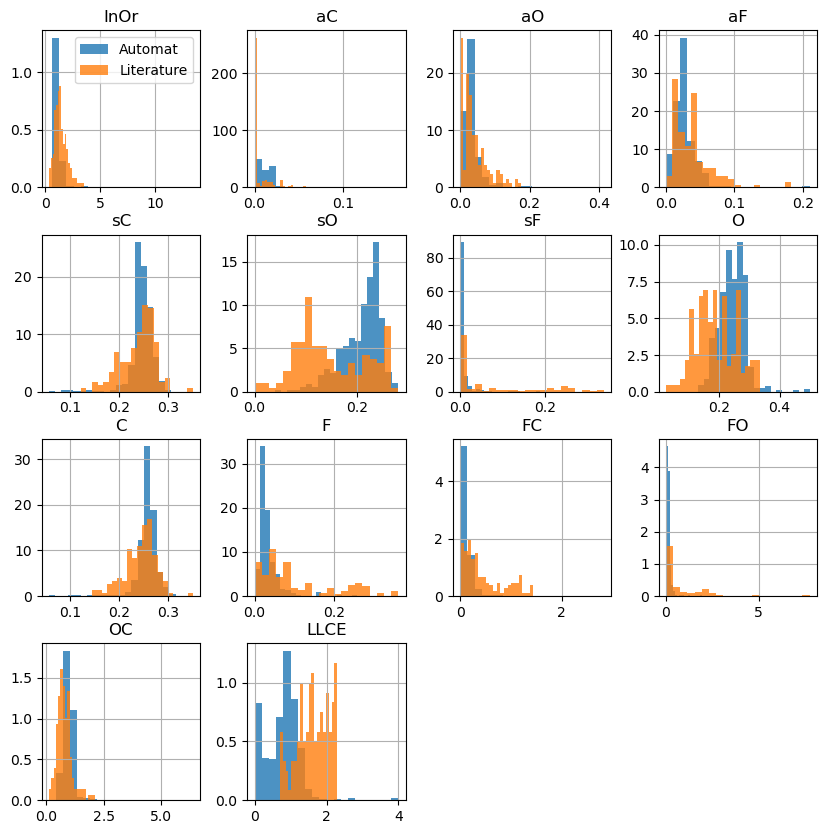

In [123]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(4, 4)
for j, col in enumerate(df_final.columns):
    ax = fig.add_subplot(gs[int(j/4), j%4])
    df_final.hist(column=col, bins=20, ax=ax, density=True, alpha=0.8, label="Automat")
    df_cy.hist(column=col, bins=20, ax=ax, density=True, alpha=0.8, label="Literature")
    if j==0: ax.legend()
plt.show()

### Results from Literature data

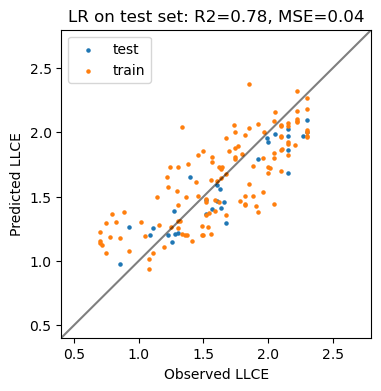

In [222]:
select = df_cy["LLCE"] > 0.5
X = df_cy.loc[select, ["sO", "aC", "InOr", "FO"]]
y_truth = df_cy.loc[select, ["LLCE"]]

X_train, X_test, y_train, y_test = train_test_split(X, y_truth, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
R2_train = model.score(X_train, y_train)

y_pred = model.predict(X_test).squeeze()
R2_test = model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(y_test, y_pred, s=5, label="test")
ax.scatter(y_train, model.predict(X_train).squeeze(), s=5, label="train")
ax.axline((2, 2), slope=1, color="k", alpha=0.5)
ax.set_title(f"LR on test set: R2={R2_test:.2f}, MSE={mse:.2f}")
ax.set_xlim([0.4, 2.8])
ax.set_ylim([0.4, 2.8])
ax.set_ylabel("Predicted LLCE")
ax.set_xlabel("Observed LLCE")
ax.legend()
plt.show()

/tmp/ipykernel_714/2018384409.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


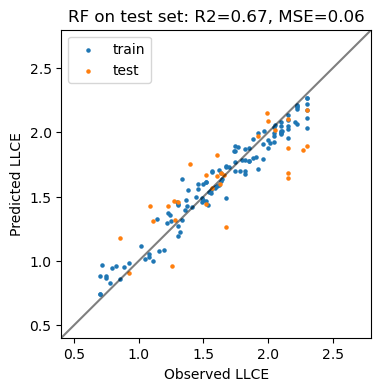

In [231]:
select = df_cy["LLCE"] > 0.5
X = df_cy.loc[select, ["sO", "aC", "InOr", "FO"]]
y_truth = df_cy.loc[select, ["LLCE"]]

X_train, X_test, y_train, y_test = train_test_split(X, y_truth, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)
R2_train = model.score(X_train, y_train)

y_pred = model.predict(X_test).squeeze()
R2_test = model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(y_train, model.predict(X_train).squeeze(), s=5, label="train")
ax.scatter(y_test, y_pred, s=5, label="test")
ax.axline((2, 2), slope=1, color="k", alpha=0.5)
ax.set_title(f"RF on test set: R2={R2_test:.2f}, MSE={mse:.2f}")
ax.set_xlim([0.4, 2.8])
ax.set_ylim([0.4, 2.8])
ax.set_ylabel("Predicted LLCE")
ax.set_xlabel("Observed LLCE")
ax.legend()
plt.show()

### Results from Automat Data

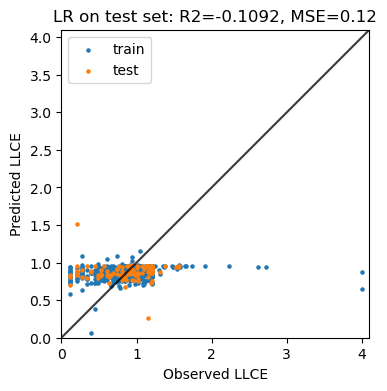

In [228]:
select = df_final["LLCE"] > 0
X = df_final.loc[select, ["sO", "aC", "InOr", "FO"]].to_numpy()
y_truth = df_final.loc[select, ["LLCE"]].to_numpy().squeeze()

X_train, X_test, y_train, y_test = train_test_split(X, y_truth, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
R2_train = model.score(X_train, y_train)

y_pred = model.predict(X_test).squeeze()
R2_test = model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.axline((1, 1), slope=1, color="k", alpha=0.5)
ax.scatter(y_train, model.predict(X_train).squeeze(), s=5, label="train")
ax.scatter(y_test, y_pred, s=5, label="test")
ax.set_aspect('equal', adjustable='box')
ax.axline((2, 2), slope=1, color="k", alpha=0.5)
ax.set_title(f"LR on test set: R2={R2_test:.4f}, MSE={mse:.2f}")
ax.set_ylabel("Predicted LLCE")
ax.set_xlabel("Observed LLCE")
ax.set_xlim([0, 4.1])
ax.set_ylim([0, 4.1])
ax.legend()
plt.show()

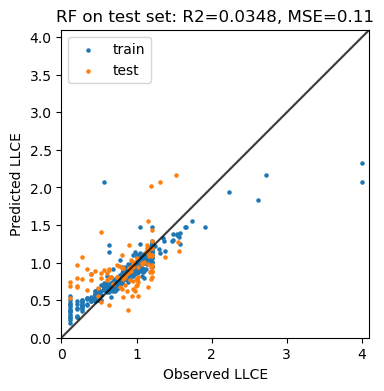

In [229]:
select = df_final["LLCE"] > 0
X = df_final.loc[select, ["sO", "aC", "InOr", "FO"]].to_numpy()
y_truth = df_final.loc[select, ["LLCE"]].to_numpy().squeeze()

X_train, X_test, y_train, y_test = train_test_split(X, y_truth, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)
R2_train = model.score(X_train, y_train)

y_pred = model.predict(X_test).squeeze()
R2_test = model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.axline((1, 1), slope=1, color="k", alpha=0.5)
ax.scatter(y_train, model.predict(X_train).squeeze(), s=5, label="train")
ax.scatter(y_test, y_pred, s=5, label="test")
# ax.axis("equal")
ax.set_aspect('equal', adjustable='box')
ax.axline((2, 2), slope=1, color="k", alpha=0.5)
ax.set_title(f"RF on test set: R2={R2_test:.4f}, MSE={mse:.2f}")
ax.set_ylabel("Predicted LLCE")
ax.set_xlabel("Observed LLCE")
ax.set_xlim([0, 4.1])
ax.set_ylim([0, 4.1])
ax.legend()
plt.show()